# **HW4 Q2**
**This is an Image classification exercise. We will play with an expired Kaggle competition, please follow the rule of Kaggle and check the following page for more information https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/overview. After submit you results, use screenshot to show you score (see
image below). They don’t provide ranking for this competition anymore. Thus, no need to show your ranking at Public/Private Leaderboard. (Name formation of your submission:MSBA.SessionX.Yourname, please replace X and Yourname with the correct string) using the screenshot on the Private Leaderboard, along with the description of your solutions and the codes (ipynb formation
is highly encouraged) as the final submission.**

# Import Package

In [1]:
import os, cv2
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

# Load Data Set

In [2]:
#! pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sallylee24","key":"8030e38bf3704708fdd2e83ff099cf25"}'}

In [5]:
# Create a kaggle directory and store your Kaggle.json file inside it
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Download Dataset
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 99% 809M/814M [00:22<00:00, 35.6MB/s]
100% 814M/814M [00:23<00:00, 37.0MB/s]


In [7]:
# Create Dataset file to store the test and train data
#!rm -r Dataset
!mkdir Dataset
!cp /content/dogs-vs-cats-redux-kernels-edition.zip  /content/Dataset/dogs-vs-cats-redux-kernels-edition.zip
!unzip -q /content/Dataset/dogs-vs-cats-redux-kernels-edition.zip -d /content/Dataset
!rm /content/Dataset/dogs-vs-cats-redux-kernels-edition.zip

In [8]:
# upzip test and train dataset
#!rm -r Dataset/test
#!rm -r Dataset/train
!unzip -q /content/Dataset/test.zip -d /content/Dataset
!unzip -q /content/Dataset/train.zip -d /content/Dataset

In [9]:
#Take a look at the test and train dataset
!ls /content/Dataset/train | head -n10
!ls /content/Dataset/test | head -n10

cat.0.jpg
cat.10000.jpg
cat.10001.jpg
cat.10002.jpg
cat.10003.jpg
cat.10004.jpg
cat.10005.jpg
cat.10006.jpg
cat.10007.jpg
cat.10008.jpg
10000.jpg
10001.jpg
10002.jpg
10003.jpg
10004.jpg
10005.jpg
10006.jpg
10007.jpg
10008.jpg
10009.jpg


# Data Exploration

Count the total image in the test and train data

<ipython-input-10-0497ed5c70e8>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


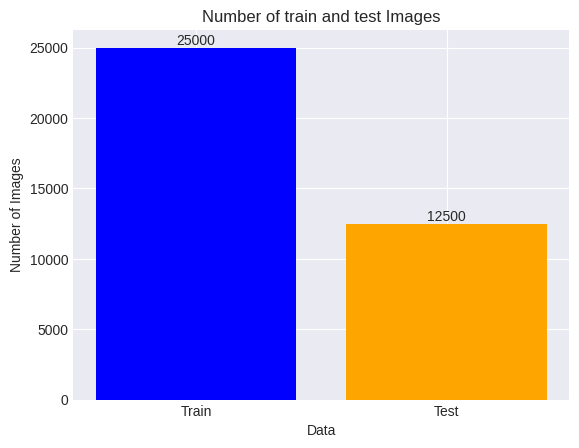

In [10]:
train_file=next(os.walk('/content/Dataset/train'))
test_file=next(os.walk('/content/Dataset/test'))
train_count = len(train_file[-1])
test_count = len(test_file[-1])

# Plotting the bar chart
categories = ['Train', 'Test']
counts = [train_count, test_count]

plt.style.use('seaborn-darkgrid')
plt.bar(categories, counts, color=['blue', 'orange'])
plt.xlabel('Data')
plt.ylabel('Number of Images')
plt.title('Number of train and test Images')

# Adding text annotations
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')

plt.show()

Count the image number of cat and dog

<ipython-input-11-2b9836067a29>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


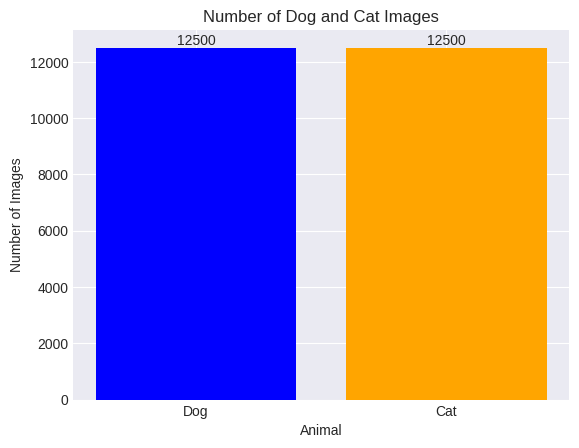

In [11]:
train = os.listdir('/content/Dataset/train')

dog_count=0
cat_count=0
for name in train:
    if name[0:3]=='dog':
        dog_count+=1
    else:
        cat_count+=1

# Plotting the bar chart
categories = ['Dog', 'Cat']
counts = [dog_count, cat_count]

plt.style.use('seaborn-darkgrid')
plt.bar(categories, counts, color=['blue', 'orange'])
plt.xlabel('Animal')
plt.ylabel('Number of Images')
plt.title('Number of Dog and Cat Images')

# Adding text annotations
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')

plt.show()

In [3]:
img_size = 224

# Build a function to read and process the images to feet the model
# The function returns the data list
def process_data(path,flag):
    data=[]
    for img in os.listdir(path):
            img_array=cv2.imread(os.path.join(path,img),cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (img_size, img_size))
            if (flag):
                data.append([new_array,img[0:3]])
            else:
                data.append(new_array)
    return data

In [4]:
# load the train data
train_path='/content/Dataset/train'
train=process_data(train_path,True)
train[0]

[array([[[151, 147, 136],
         [150, 147, 135],
         [150, 146, 135],
         ...,
         [ 93,  90,  83],
         [ 89,  84,  80],
         [ 85,  80,  76]],
 
        [[157, 153, 142],
         [155, 151, 140],
         [156, 152, 141],
         ...,
         [ 97,  94,  85],
         [ 92,  89,  81],
         [ 88,  85,  77]],
 
        [[155, 151, 140],
         [154, 150, 139],
         [154, 150, 139],
         ...,
         [ 96,  94,  82],
         [ 93,  91,  79],
         [ 89,  87,  75]],
 
        ...,
 
        [[255, 254, 250],
         [255, 254, 250],
         [255, 254, 250],
         ...,
         [218, 216, 209],
         [202, 199, 187],
         [183, 180, 169]],
 
        [[253, 251, 247],
         [253, 251, 247],
         [253, 251, 247],
         ...,
         [199, 192, 190],
         [209, 201, 193],
         [210, 202, 194]],
 
        [[255, 251, 248],
         [255, 251, 248],
         [255, 251, 248],
         ...,
         [ 82,  71,  81],
  

In [19]:
# load the test data
test_path='/content/Dataset/test'
test=process_data(test_path,True)
test[0]

[array([[[227, 154, 192],
         [230, 157, 195],
         [230, 157, 195],
         ...,
         [203, 136, 165],
         [194, 130, 159],
         [195, 131, 160]],
 
        [[231, 157, 195],
         [230, 157, 195],
         [228, 155, 193],
         ...,
         [207, 141, 170],
         [195, 131, 160],
         [197, 133, 162]],
 
        [[230, 157, 195],
         [232, 159, 197],
         [232, 159, 197],
         ...,
         [206, 140, 169],
         [203, 137, 166],
         [202, 137, 166]],
 
        ...,
 
        [[138,  96, 121],
         [136,  94, 118],
         [133,  93, 118],
         ...,
         [141, 137, 136],
         [ 95, 103, 106],
         [146, 156, 160]],
 
        [[135,  93, 118],
         [136,  94, 119],
         [133,  93, 118],
         ...,
         [148, 144, 143],
         [117, 124, 127],
         [147, 158, 162]],
 
        [[141,  99, 124],
         [133,  90, 116],
         [132,  92, 117],
         ...,
         [161, 157, 156],
  

Show the image

In [6]:
# Define a funtion to show the first 10 images
def show_images(data,flag):
    plt.figure(figsize=(15,15))
    ii=1
    for i,data in enumerate(data[:10]):
        label = data[1]
        img_data = data[0]
        if(flag):
            label="None"
        plt.subplot(5,5,ii)
        plt.imshow(img_data)
        plt.axis('off')
        plt.title("Label: {}".format(label))
        ii+=1

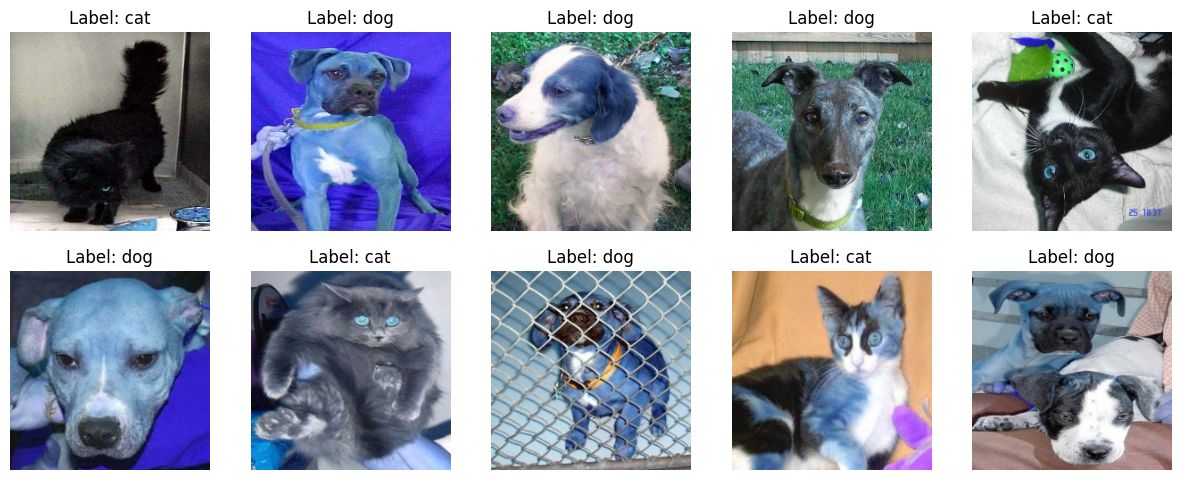

In [7]:
# Show the train images
show_images(train,False)

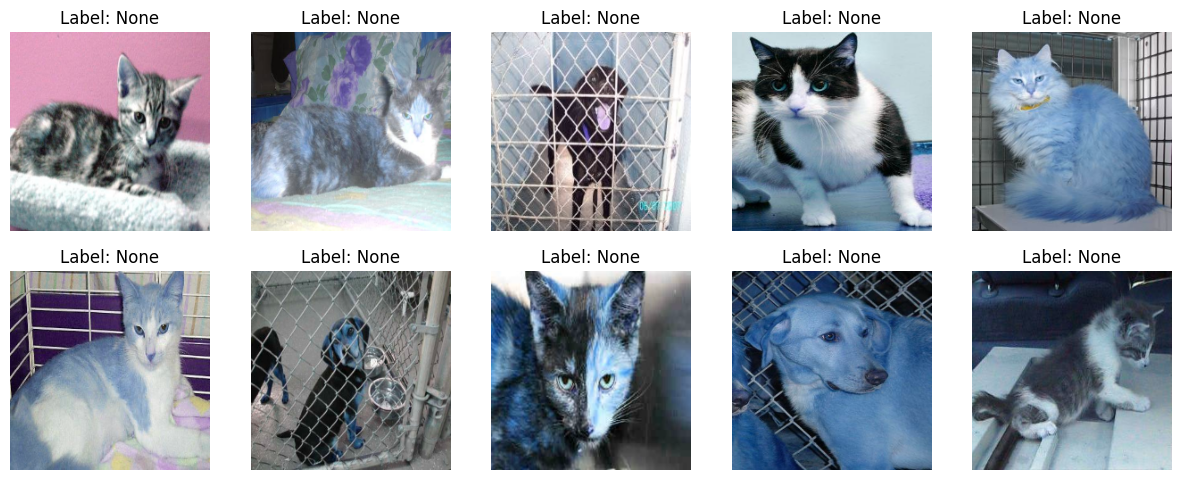

In [8]:
# Show the test images
show_images(test,True)

# Data Preprocessing

In [18]:
X = np.array([i[0] for i in train]).reshape(-1,img_size,img_size,3)
y = np.array([1 if i[1]=='dog' else 0 for i in train])

In [19]:
# Split train data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

In [20]:
# Use ImageDataGenerator to do data augmentation

batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train,
                                     y_train,
                                     batch_size=batch_size,
                                     seed = 42)

val_generator = train_datagen.flow(X_val,
                                   y_val,
                                   batch_size=batch_size,
                                   seed = 42)

# Build CNN model with COV2D

## Prepare the model

In [21]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# CNN 1
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# CNN 2
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# CNN 3
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fully Connected layers
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 64)      2

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Train the model

In [23]:
train_model = model.fit(train_generator,
                  batch_size=batch_size,
                  epochs=32,
                  verbose=1,
                  validation_data=val_generator)

Epoch 1/32
625/625 [==============================] - 256s 386ms/step - loss: 0.6934 - accuracy: 0.6300 - val_loss: 0.6657 - val_accuracy: 0.6194
Epoch 2/32
625/625 [==============================] - 242s 387ms/step - loss: 0.5599 - accuracy: 0.7081 - val_loss: 0.5163 - val_accuracy: 0.7456
Epoch 3/32
625/625 [==============================] - 248s 396ms/step - loss: 0.4885 - accuracy: 0.7642 - val_loss: 0.6105 - val_accuracy: 0.7174
Epoch 4/32
625/625 [==============================] - 243s 389ms/step - loss: 0.4175 - accuracy: 0.8100 - val_loss: 0.4544 - val_accuracy: 0.7866
Epoch 5/32
625/625 [==============================] - 241s 385ms/step - loss: 0.3601 - accuracy: 0.8395 - val_loss: 0.5420 - val_accuracy: 0.7582
Epoch 6/32
625/625 [==============================] - 241s 385ms/step - loss: 0.3405 - accuracy: 0.8500 - val_loss: 0.6146 - val_accuracy: 0.7056
Epoch 7/32
625/625 [==============================] - 240s 384ms/step - loss: 0.3136 - accuracy: 0.8618 - val_loss: 0.2961 -

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# save the model
#model.save('/content/cnn_32epochs.keras')

Plot the train and validation accuracy

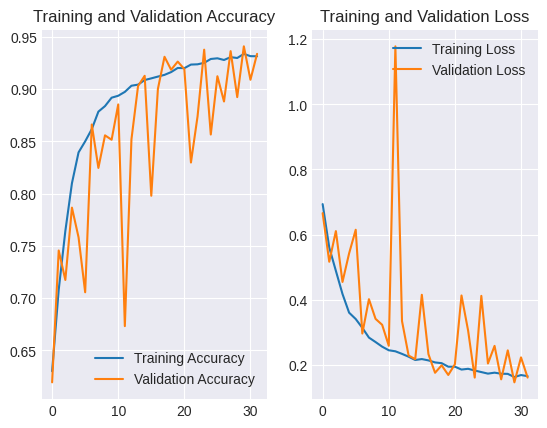

In [29]:
acc = train_model.history['accuracy']
val_acc = train_model.history['val_accuracy']

loss = train_model.history['loss']
val_loss = train_model.history['val_loss']

epochs_range = range(32)


plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Predict the test data

In [10]:
loadded_model = tf.keras.models.load_model('/content/cnn_32epochs.keras')

In [23]:
# loading into dataframe
test_dir = "/content/Dataset/test"
filenames = os.listdir(test_dir)
test_data = pd.DataFrame({"filename": filenames})
test_data['label'] = 'unknown'

test_datagen = ImageDataGenerator(rescale=1./255)
# Create data genenerator for test data
test1_idg =  test_datagen.flow_from_dataframe(test_data,
                                     test_dir,
                                     x_col= "filename",
                                     y_col = 'label',
                                     batch_size = 32,
                                     target_size=(224,224),
                                     shuffle = False)

Found 12500 validated image filenames belonging to 1 classes.


In [25]:
result = loadded_model.predict(test1_idg)

391/391 [==============================] - 24s 62ms/step


In [31]:
result

array([[0.03192793],
       [0.00342906],
       [0.9966546 ],
       ...,
       [0.992823  ],
       [0.4292978 ],
       [0.9999976 ]], dtype=float32)

In [35]:
id = np.array(range(1,12501))
submission = pd.DataFrame(result,columns=['label'])
submission.insert(0,'id',id)
submission.head()

,id,label
0,1,3.192793e-02
1,2,3.429063e-03
2,3,9.966546e-01
3,4,9.904851e-10
4,5,1.934978e-04


In [36]:
# save submission to csv
submission.to_csv('MSBA.Session2.SsuHsienLee_cnn.csv',index= False)
from google.colab import files
files.download('MSBA.Session2.SsuHsienLee_cnn.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Reference

*   https://www.kaggle.com/code/suyashviraaj/cats-or-dogs-using-cnn-with-transfer-learning
*   https://www.kaggle.com/code/ahmedashrafahmed/dogs-vs-cats-redux-kernels-using-resnet50-98
*   https://www.kaggle.com/code/gulshanmishra/tensorflow-baseline
*   https://github.com/ovh/ai-training-examples/blob/main/notebooks/computer-vision/image-classification/tensorflow/resnet50/notebook-resnet-transfer-learning-image-classification.ipynb
*   https://github.com/guilhermedom/resnet50-transfer-learning-cats-and-dogs/blob/main/notebooks/1.0-gdfs-resnet50-transfer-learning-cats-and-dogs.ipynb
*   https://www.kaggle.com/code/ansumansamal/dogs-vs-cats
*   https://www.kaggle.com/code/sachinpatil1280/cats-vs-dogs-image-classification-using-cnn-95








